In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.cluster import KMeans

from deep_clustering import DeepClustering
from utils.training_and_visualisation import plot_losses, train
from utils.parametric_umap import NumpyToTensorDataset, FastTensorDataLoader, compute_neighbour_matrix, make_neighbor_indices, ContrastiveLoss

from tqdm.notebook import trange


PATH = "embeds/"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
embs_train = torch.load(PATH + "t5_train.pt")
embs_test = torch.load(PATH + "t5_test.pt")

In [3]:
embs_train.shape

torch.Size([10003, 1024])

# Test

## Create dataset

In [4]:
A = (torch.randn(550, 2) @ torch.Tensor([[1., 2.], [-3., 5]])) + torch.Tensor([17., 12.])
B = (torch.randn(150, 2) @ torch.Tensor([[10., 0.], [0., 10]])) + torch.Tensor([-24., 25.])
C = (torch.randn(350, 2) @ torch.Tensor([[8., 10.], [-10., 2]])) + torch.Tensor([12., -36.])

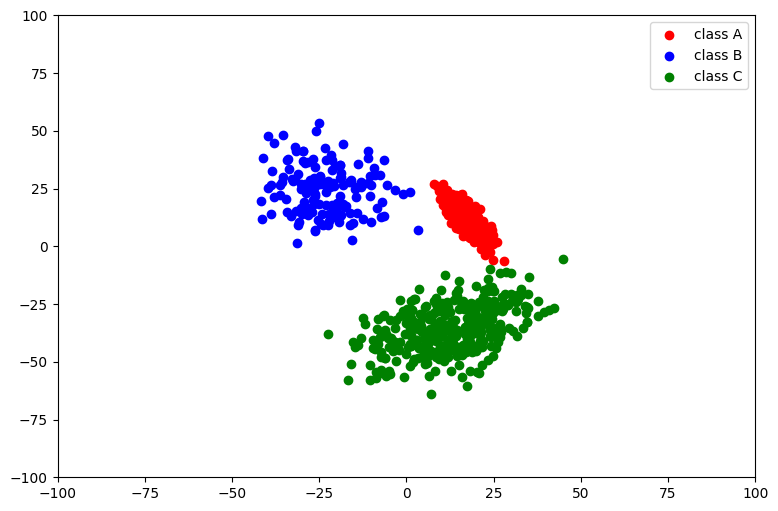

In [5]:
plt.figure(figsize=(9, 6))
plt.scatter(A[:, 0], A[:, 1], color='r', label='class A')
plt.scatter(B[:, 0], B[:, 1], color='b', label='class B')
plt.scatter(C[:, 0], C[:, 1], color='g', label='class C')
plt.legend()
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.show()

In [6]:
data = torch.cat([A, B, C])

In [7]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(data)

In [8]:
torch.tensor(kmeans.cluster_centers_)

tensor([[ 12.0849, -36.1082],
        [ 17.2331,  11.4045],
        [-23.6795,  24.6872]], dtype=torch.float64)

## Train embeds (very bad / doesn't work)

In [9]:
N_ITERS = 100
LR = 3e-2

#model = DeepClustering(3, 2, 2, 14, cluster_centers_init=torch.tensor(kmeans.cluster_centers_)).to(device)
model = DeepClustering(3, 2, 2, 14, loss_weights=[1., 0.]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataloader = DataLoader(data, batch_size=128, shuffle=True)

In [10]:
next(iter(dataloader)).shape

torch.Size([64, 2])

In [11]:
losses = train(model, dataloader, optimizer, N_ITERS, device)

  0%|          | 0/100 [00:00<?, ?it/s]

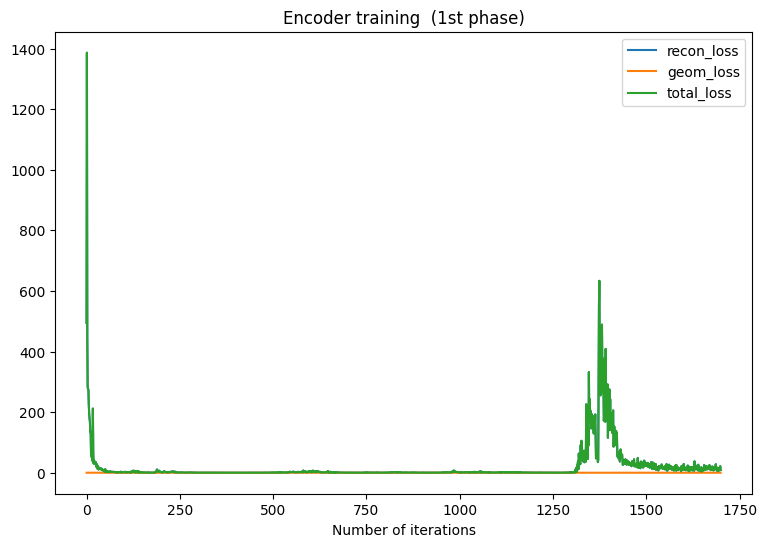

In [12]:
plot_losses(losses, "Encoder training  (1st phase)")

## Train clusters

In [13]:
model = DeepClustering(3, 2, 2, 4, loss_weights=[1., 0.]).to(device)
model.enc = nn.Identity(2)
model.dec = nn.Identity(2)

In [14]:
N_ITERS = 100
LR = 3e-2

#model = DeepClustering(3, 2, 2, 14, cluster_centers_init=torch.tensor(kmeans.cluster_centers_)).to(device)
model.train_clusters(data.to(device), [0.1, 0., 0.9])
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataloader = DataLoader(data, batch_size=128, shuffle=True)

In [15]:
model.centers

Parameter containing:
tensor([[ 12.0849, -36.1082],
        [ 17.2331,  11.4045],
        [-23.6795,  24.6872]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

In [16]:
losses = train(model, dataloader, optimizer, N_ITERS, device)

  0%|          | 0/100 [00:00<?, ?it/s]

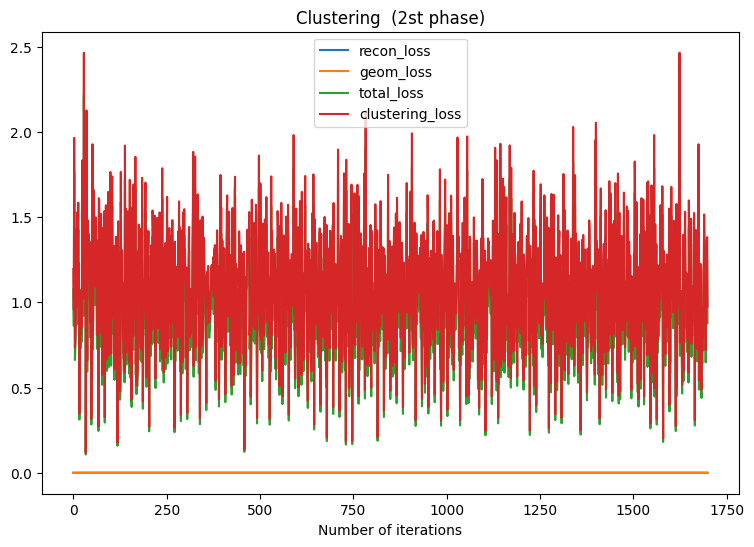

In [17]:
plot_losses(losses, "Clustering  (2st phase)")

In [18]:
torch.tensor(kmeans.cluster_centers_)

tensor([[ 12.0849, -36.1082],
        [ 17.2331,  11.4045],
        [-23.6795,  24.6872]], dtype=torch.float64)

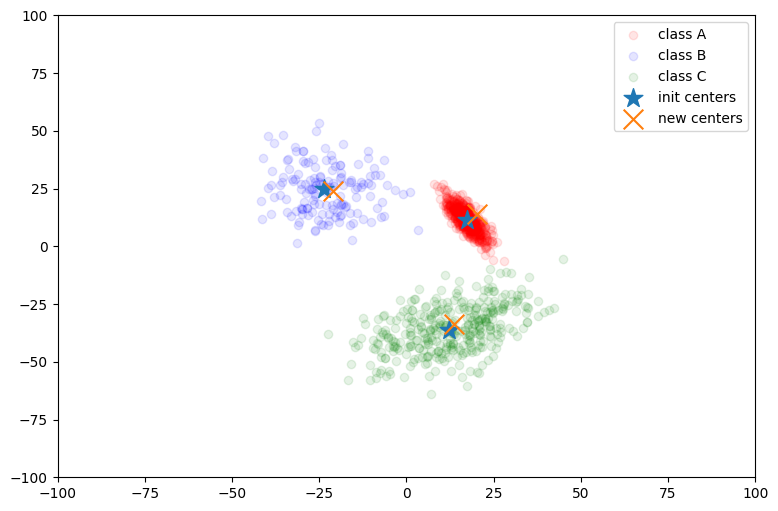

In [19]:
new_centers = model.centers.cpu().detach().numpy()
A_emb = model.enc(A.to(device)).cpu()
B_emb = model.enc(B.to(device)).cpu()
C_emb = model.enc(C.to(device)).cpu()

plt.figure(figsize=(9, 6))
#plt.scatter(A[:, 0], A[:, 1], color='r', alpha=0.1, label='class A')
plt.scatter(A_emb[:, 0], A_emb[:, 1], color='r', alpha=0.1, label='class A')
#plt.scatter(B[:, 0], B[:, 1], color='b', alpha=0.1, label='class B')
plt.scatter(B_emb[:, 0], B_emb[:, 1], color='b', alpha=0.1, label='class B')
#plt.scatter(C[:, 0], C[:, 1], color='g', alpha=0.1, label='class C')
plt.scatter(C_emb[:, 0], C_emb[:, 1], color='g', alpha=0.1, label='class C')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='*', label='init centers', s=200)
plt.scatter(new_centers[:, 0], new_centers[:, 1], marker='x', label='new centers', s=200)
plt.legend()
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.show()